In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [ ]:
masks = glob.glob("/content/drive/MyDrive/mini_project/mini_project_sigmintation/final/finalMasks/*.png")
orgs = glob.glob("/content/drive/MyDrive/mini_project/mini_project_sigmintation/final/finalImages/*.png")

In [ ]:
orgs = orgs[31:]
masks = masks[31:]

In [ ]:
#abother try of loading
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((256,256))))

    im = Image.open(mask).resize((256,256))
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [ ]:
print(imgs_np.shape, masks_np.shape)

(639, 256, 256) (639, 256, 256)


## Plot images + masks + overlay (mask over original)

In [ ]:
!pip install keras_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


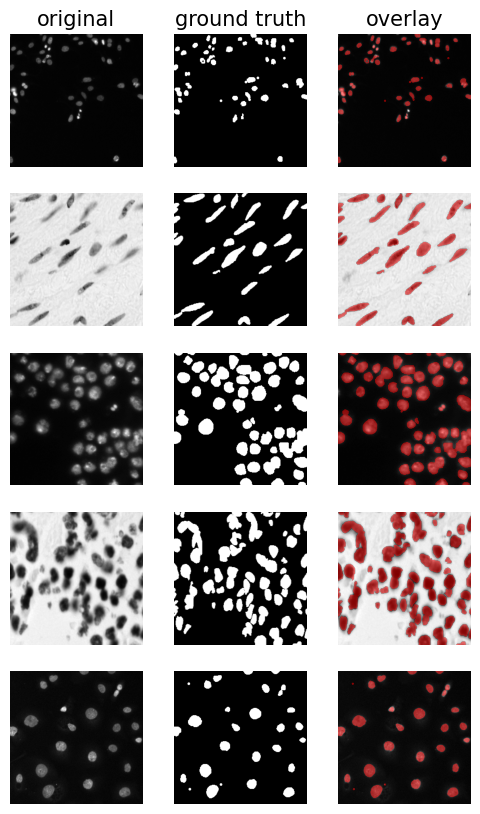

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=5, figsize=2)


## Get data into correct shape, dtype and range (0.0-1.0)

In [ ]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

In [ ]:
print(x.max(), y.max())

1.0 1.0


In [ ]:
print(x.shape, y.shape)

(639, 256, 256) (639, 256, 256)


In [ ]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(639, 256, 256) (639, 256, 256, 1)


In [ ]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape, y.shape)

(639, 256, 256, 1) (639, 256, 256, 1)


##  Train/val split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(x_val, y_val, test_size=0.3, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_valid.shape)
print("y_val: ", y_valid.shape)
print("y_val: ", x_test.shape)


x_train:  (447, 256, 256, 1)
y_train:  (447, 256, 256, 1)
x_val:  (134, 256, 256, 1)
y_val:  (134, 256, 256, 1)
y_val:  (58, 256, 256, 1)


## Prepare train generator with data augmentation

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(8, 256, 256, 1) (8, 256, 256, 1)


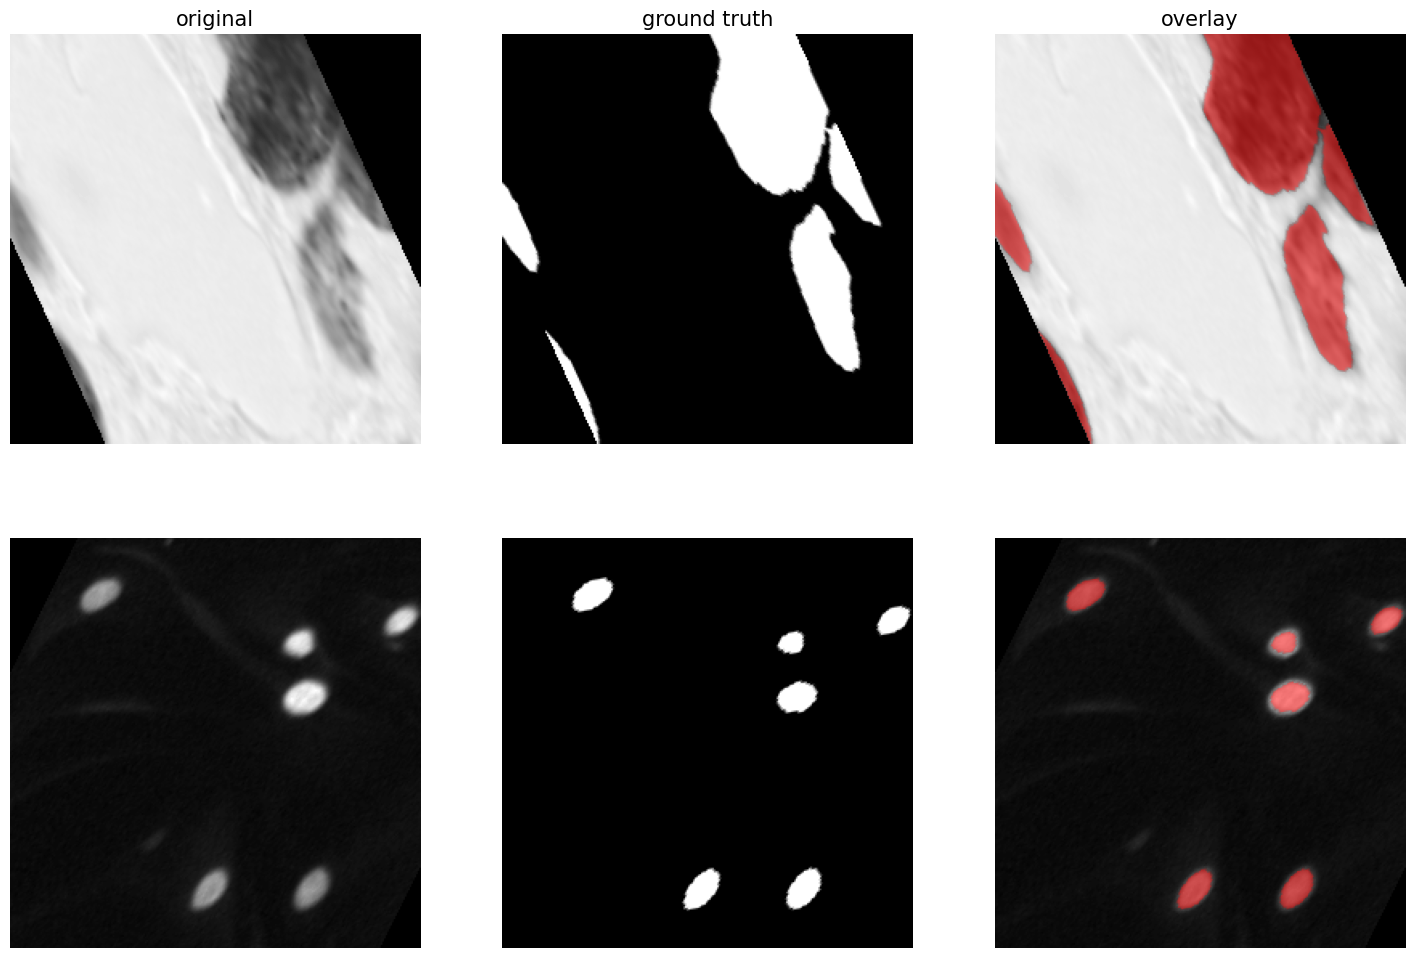

In [ ]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_layer = Input((128, 128, 3))
#output_layer = get_unet_128(input_layer, n_classes=1)

def get_unet_128(input_shape=(128, 128, 3), num_classes=1):
    input_layer = Input(input_shape)

    # contracting path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    # expansive path
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    output_layer = Conv2D(1, 1, activation='sigmoid')(conv9)

    return Model(inputs=input_layer, outputs=output_layer)


## Initialize network

In [ ]:
from keras_unet.models import custom_unet

input_shape = x_train.shape[1:]

model = get_unet_128(input_shape=input_shape, num_classes=1)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin\\"

In [ ]:
import sys
print(sys.path)

sys.path.append("C:\\Program Files (x86)\\Graphviz2.38\\bin\\")

print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\']


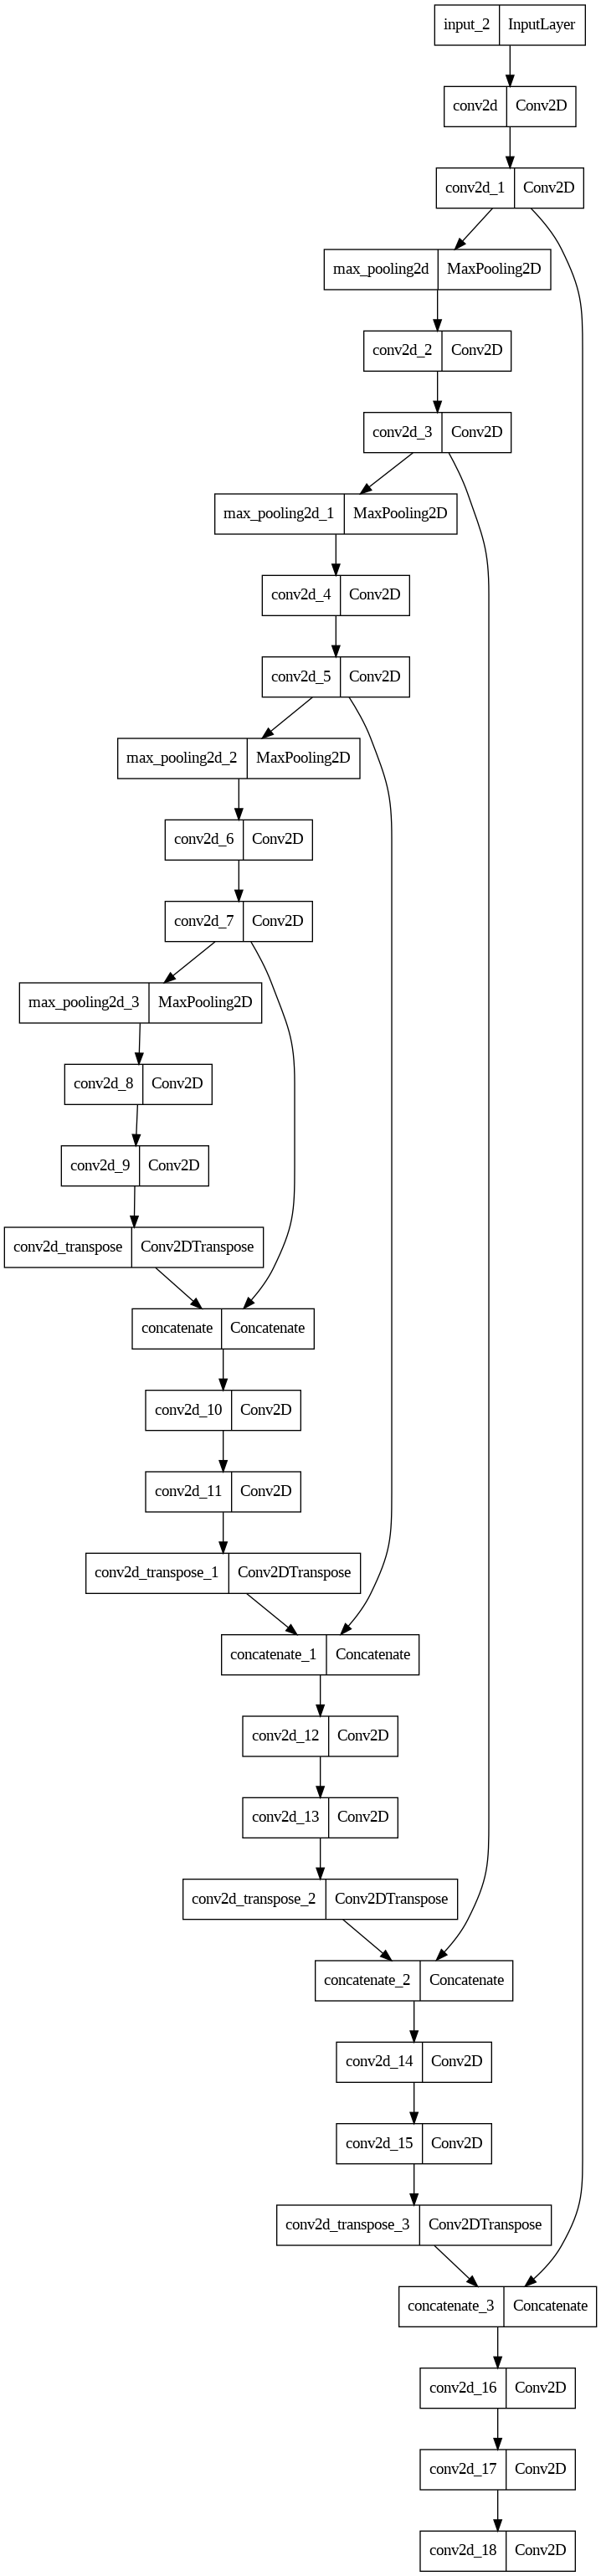

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Compile + train

In [ ]:
from keras.callbacks import ModelCheckpoint


model_filename = '/content/drive/MyDrive/mini_project/mini_project_sigmintation/segm_model1_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

In [ ]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(),
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit_generator(
    train_gen,
    steps_per_epoch= x_train.shape[0]/8,
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping]
  )


Epoch 1/100


<ipython-input-25-760604007466>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


55/55 [==============================] - 41s 388ms/step - loss: 0.4598 - iou: 0.0713 - iou_thresholded: 9.2734e-05 - val_loss: 0.3690 - val_iou: 0.0737 - val_iou_thresholded: 7.7413e-06
Epoch 2/100
55/55 [==============================] - 8s 145ms/step - loss: 0.3719 - iou: 0.0642 - iou_thresholded: 1.6912e-05 - val_loss: 0.3438 - val_iou: 0.0774 - val_iou_thresholded: 7.7413e-06
Epoch 3/100
55/55 [==============================] - 9s 158ms/step - loss: 0.2812 - iou: 0.2295 - iou_thresholded: 0.2594 - val_loss: 0.1801 - val_iou: 0.4504 - val_iou_thresholded: 0.5089
Epoch 4/100
55/55 [==============================] - 8s 148ms/step - loss: 0.2824 - iou: 0.3018 - iou_thresholded: 0.3520 - val_loss: 0.3912 - val_iou: 0.1593 - val_iou_thresholded: 0.1640
Epoch 5/100
55/55 [==============================] - 9s 156ms/step - loss: 0.3606 - iou: 0.1377 - iou_thresholded: 0.1074 - val_loss: 0.2893 - val_iou: 0.3605 - val_iou_thresholded: 0.5940
Epoch 6/100
55/55 [==============================]

## Plot training history

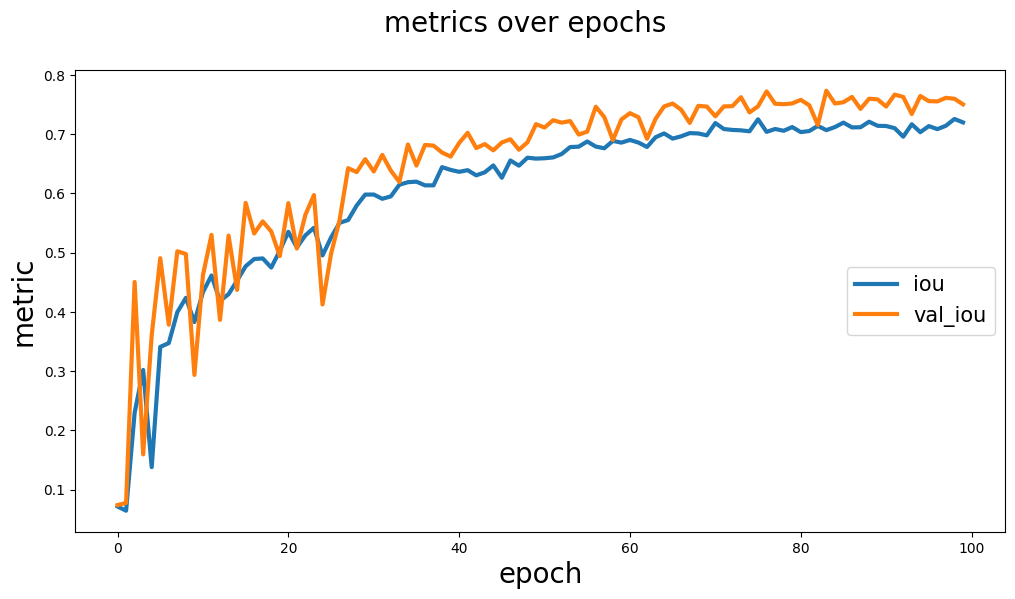

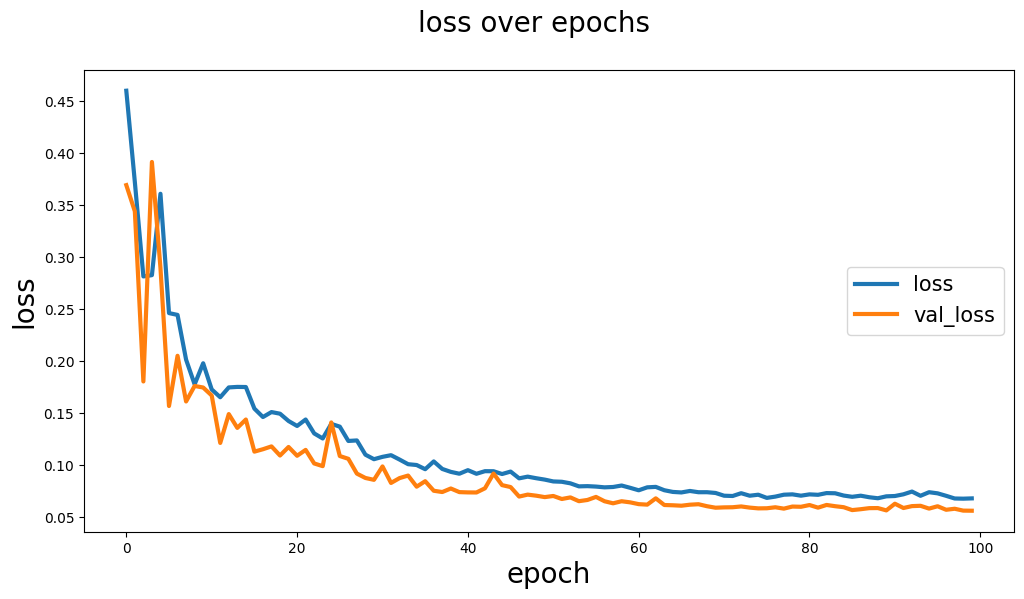

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [ ]:
model_filepath = "/content/drive/MyDrive/mini_project/project_segmentation/final_datas/segm_model_try4.h5"  #change here for type of models
model.load_weights(model_filepath)
y_pred = model.predict(x_test)

2/2 [==============================] - 5s 5s/step


In [ ]:
b = np.where(y_pred*255 > 100, 255, 0)

In [ ]:
import numpy as np

# Assuming you have the trained model: model
# Assuming you have the ground truth masks for the test set: y_test_masks

# Make predictions on the test set
#y_pred_masks = model.predict(X_test)

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou_scores = []

for i in range(len(b)):
    y_pre = b[i]
    y_tru = y_test[i]
    iou_score = calculate_iou(y_tru, y_pre)
    iou_scores.append(iou_score)

# Print the average IoU score
avg_iou = np.mean(iou_scores)
print("Average IoU:",avg_iou)

Average IoU: 0.7929464584006305


In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(x_test, y_test)

print("Test Loss:", loss)

2/2 [==============================] - 0s 137ms/step - loss: 0.0916 - iou: 0.7114 - iou_thresholded: 0.7890
Test Loss: [0.09160216152667999, 0.711441695690155, 0.7889556884765625]


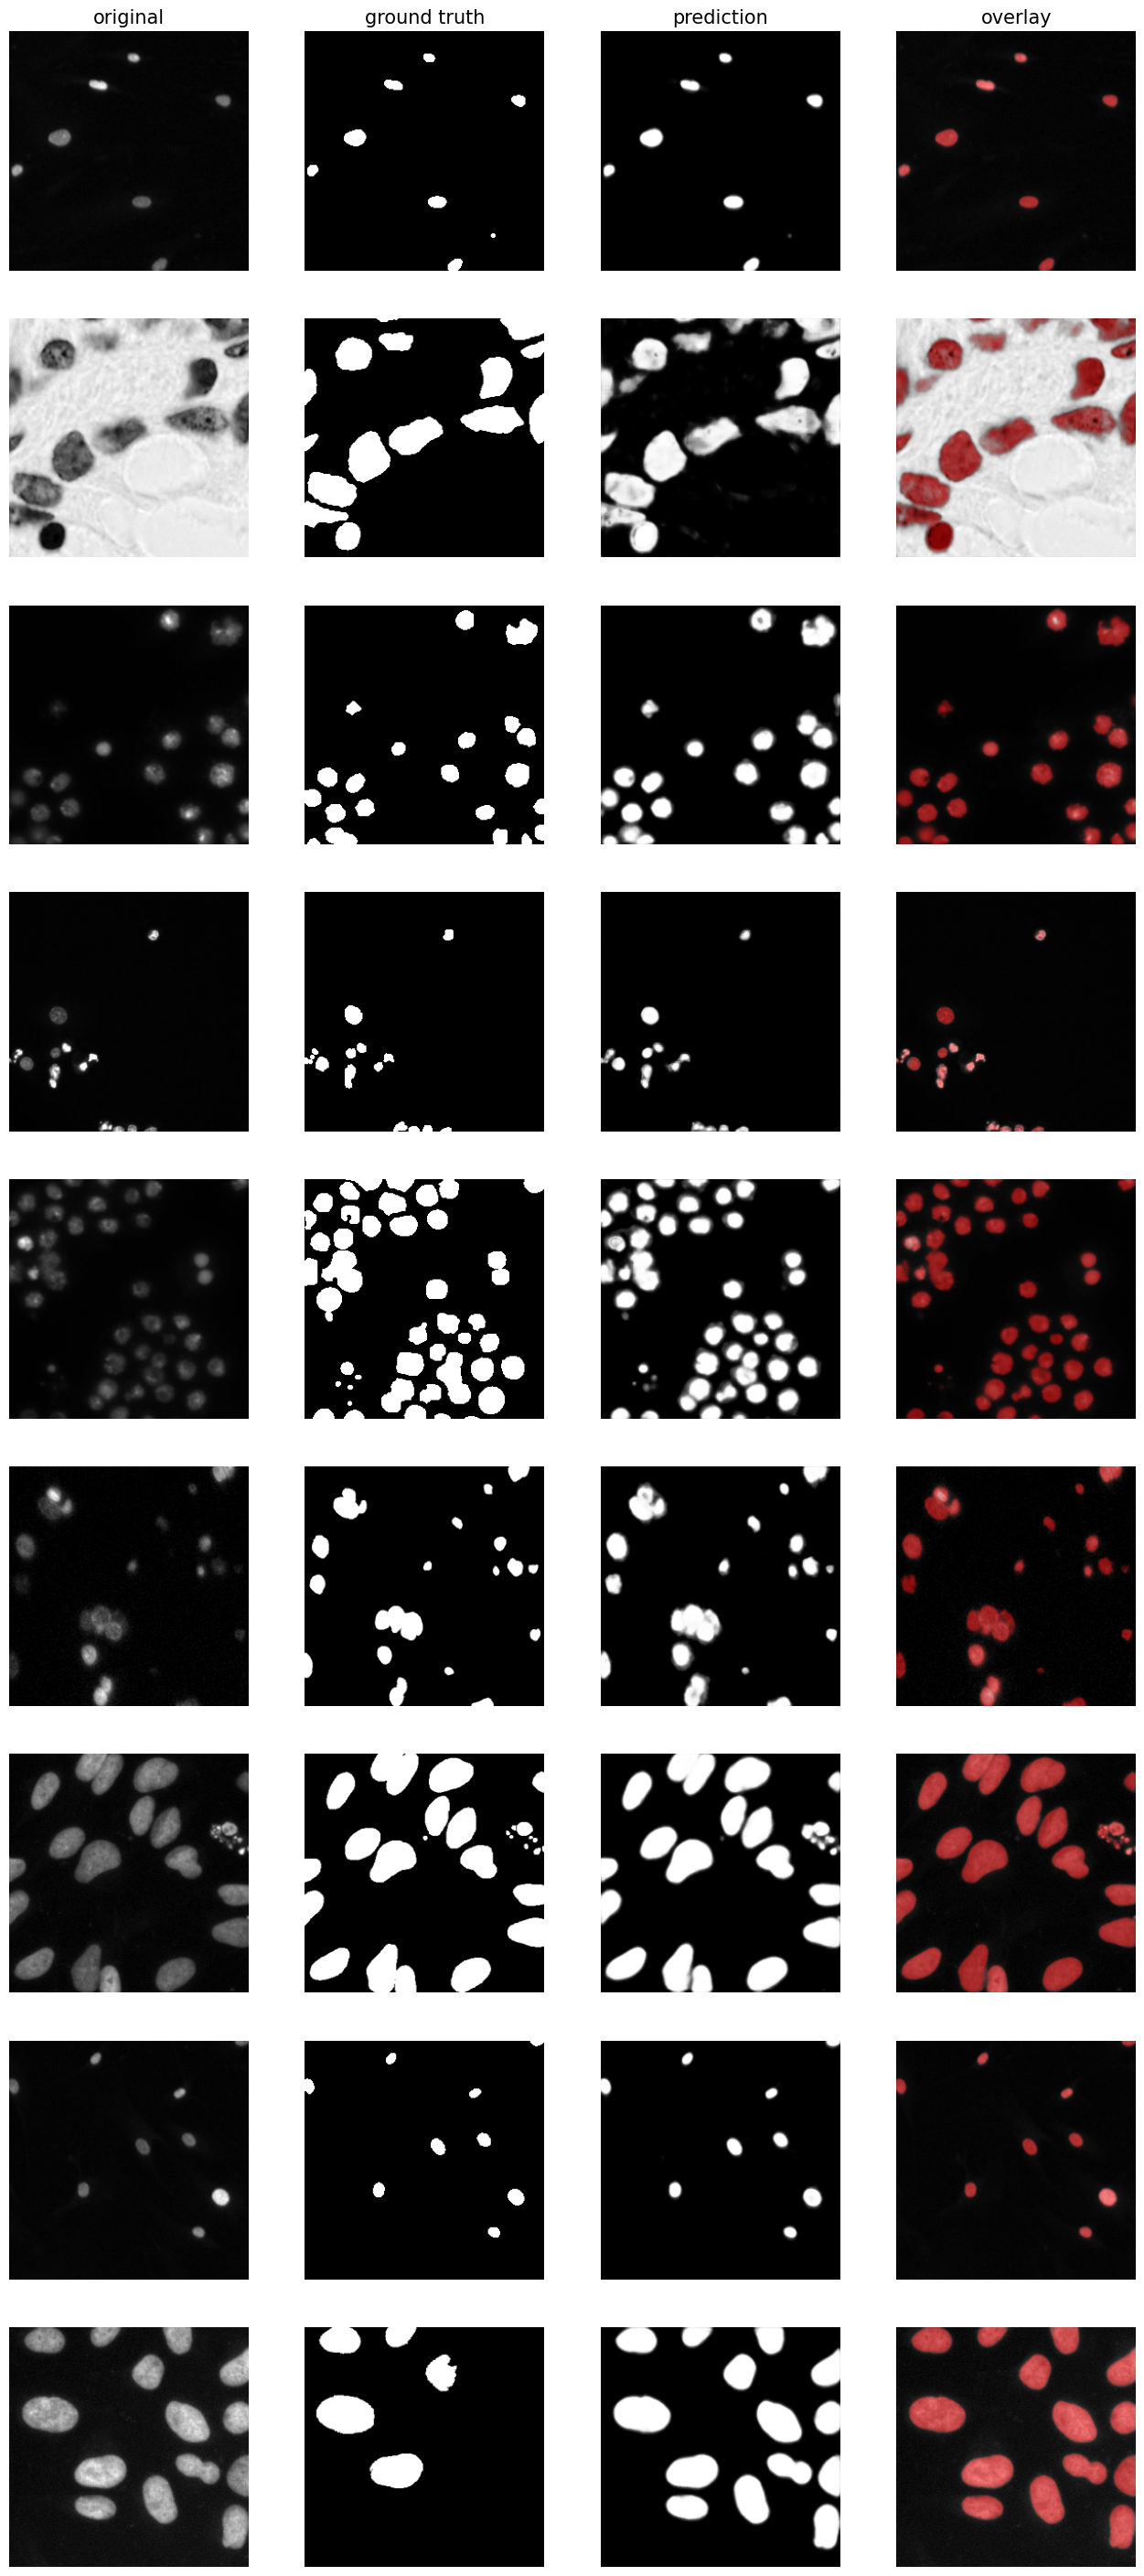

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)